#  Evaluation of TinyLlama-1.1B-Chat on MedMCQA Dataset

This notebook evaluates the performance of the `TinyLlama-1.1B-Chat-v1.0` model on the `MedMCQA` dataset using various prompting techniques.

## Methods Implemented
- Zero-Shot Prompting
- Few-Shot Prompting
- Chain-of-Thought Prompting
- Tree-of-Thought (Simulated)
- Self-Consistency


In [ ]:
!pip install -q transformers datasets sentence-transformers faiss-cpu matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, util
import faiss
import random
import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [ ]:
# Load TinyLlama model and tokenizer
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32).to(device)

# Load MedMCQA dataset (subset for quick evaluation)
dataset = load_dataset("medmcqa", split="validation[:1000]")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/85.9M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/936k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.48M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/182822 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6150 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4183 [00:00<?, ? examples/s]

In [ ]:
# Select few-shot examples from the training set
train_dataset = load_dataset("medmcqa", split="train[:1000]")
few_shot_examples = [train_dataset[i] for i in range(10)]  # pick 10 few-shot examples

In [ ]:
def get_prediction(prompt, max_tokens=30):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(**inputs, max_new_tokens=max_tokens, do_sample=False)
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Try extracting final letter (A/B/C/D) from output
    for letter in ["A", "B", "C", "D"]:
        if f"Answer: {letter}" in decoded:
            return letter
    # Fallback: check for any option letter as final token
    decoded_clean = decoded.strip().split()
    for token in reversed(decoded_clean):
        if token in ["A", "B", "C", "D"]:
            return token
    return None


In [ ]:
def generate_prompt(example, style="zero-shot", few_shot_examples=None):
    question = example["question"]
    options = f"A: {example['opa']}\nB: {example['opb']}\nC: {example['opc']}\nD: {example['opd']}"

    if style == "zero-shot":
        return f"Question: {question}\n{options}\nAnswer:"

    elif style == "few-shot":
        prompt = ""
        for shot in few_shot_examples:
            shot_q = shot["question"]
            shot_opts = f"A: {shot['opa']}\nB: {shot['opb']}\nC: {shot['opc']}\nD: {shot['opd']}"
            shot_ans = ["A", "B", "C", "D"][shot["cop"]]
            prompt += f"Question: {shot_q}\n{shot_opts}\nAnswer: {shot_ans}\n\n"
        return prompt + f"Question: {question}\n{options}\nAnswer:"

    elif style == "cot":
      return (
          f"Question: {question}\n"
          f"{options}\n"
          "Let's carefully analyze this medical question step by step:\n"
          "1. Identify the key symptoms or clues in the question.\n"
          "2. Recall relevant medical knowledge.\n"
          "3. Eliminate unlikely options.\n"
          "4. Choose the most likely answer based on reasoning.\n"
          "Answer:"
      )


    else:
        raise ValueError(f"Unsupported style: {style}")


In [ ]:
def get_answer_letter(index):
    return ["A", "B", "C", "D"][index]

def get_answer_index(letter):
    return {"A": 0, "B": 1, "C": 2, "D": 3}[letter]

def evaluate(dataset, style="zero-shot", n=100, few_shot_examples=None):
    correct = 0
    total = min(n, len(dataset))

    for i in range(total):
        example = dataset[i]
        prompt = generate_prompt(example, style=style, few_shot_examples=few_shot_examples)
        pred_letter = get_prediction(prompt)

        actual = get_answer_letter(example["cop"])
        if pred_letter is not None and pred_letter == actual:
            correct += 1

    accuracy = correct / total
    return accuracy


In [ ]:
def tree_of_thought_prompt(example):
    question = example["question"]
    options = f"A: {example['opa']}\nB: {example['opb']}\nC: {example['opc']}\nD: {example['opd']}"
    return (
        f"Question: {question}\n{options}\n"
        "Let's explore multiple reasoning paths:\n"
        "Path 1: Consider general medical knowledge.\n"
        "Path 2: Analyze the symptoms and match with known conditions.\n"
        "Path 3: Eliminate unlikely options logically.\n"
        "Final Answer:"
    )

def evaluate_tot(dataset, n=100):
    correct = 0
    total = min(n, len(dataset))
    for i in range(total):
        example = dataset[i]
        prompt = tree_of_thought_prompt(example)
        pred_letter = get_prediction(prompt)
        if pred_letter is not None and get_answer_index(pred_letter) == example["cop"]:
            correct += 1
    return correct / total


In [ ]:
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np

retriever = SentenceTransformer("all-MiniLM-L6-v2")
explanations = [ex["exp"] if ex["exp"] is not None else "" for ex in dataset]
corpus_embeddings = retriever.encode(explanations, convert_to_tensor=False)

index = faiss.IndexFlatL2(len(corpus_embeddings[0]))
index.add(np.array(corpus_embeddings))


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
from sentence_transformers import SentenceTransformer, util

# Load model for semantic similarity
semantic_model = SentenceTransformer("all-MiniLM-L6-v2")
train_dataset = load_dataset("medmcqa", split="train[:1000]")  # larger set = better match
train_embeddings = semantic_model.encode([ex["question"] for ex in train_dataset], convert_to_tensor=True)

def get_semantic_few_shot_examples(test_question, k=5):
    query_embedding = semantic_model.encode(test_question, convert_to_tensor=True)
    scores = util.pytorch_cos_sim(query_embedding, train_embeddings)[0]
    top_k_indices = torch.topk(scores, k=k).indices
    return [train_dataset[i.item()] for i in top_k_indices]


In [ ]:
from collections import Counter

def evaluate_self_consistency(dataset, n=100, k_votes=5, k_shots=5):
    correct = 0
    total = min(n, len(dataset))

    for i in range(total):
        test_example = dataset[i]
        few_shot_examples = get_semantic_few_shot_examples(test_example["question"], k=k_shots)
        prompt = generate_prompt(test_example, style="few-shot", few_shot_examples=few_shot_examples)

        predictions = [get_prediction(prompt) for _ in range(k_votes)]
        predictions = [p for p in predictions if p is not None]
        if not predictions:
            continue

        majority_vote = Counter(predictions).most_common(1)[0][0]
        if get_answer_index(majority_vote) == test_example["cop"]:
            correct += 1

    return correct / total


In [ ]:
promptsUsed=generate_prompt(dataset[:1], style="few-shot", few_shot_examples=few_shot_examples)

In [ ]:
print(promptsUsed)

Question: Chronic urethral obstruction due to benign prismatic hyperplasia can lead to the following change in kidney parenchyma
A: Hyperplasia
B: Hyperophy
C: Atrophy
D: Dyplasia
Answer: C

Question: Which vitamin is supplied from only animal source:
A: Vitamin C
B: Vitamin B7
C: Vitamin B12
D: Vitamin D
Answer: C

Question: All of the following are surgical options for morbid obesity except -
A: Adjustable gastric banding
B: Biliopancreatic diversion
C: Duodenal Switch
D: Roux en Y Duodenal By pass
Answer: D

Question: Following endaerectomy on the right common carotid, a patient is found to be blind in the right eye. It is appears that a small thrombus embolized during surgery and lodged in the aery supplying the optic nerve. Which aery would be blocked?
A: Central aery of the retina
B: Infraorbital aery
C: Lacrimal aery
D: Nasociliary aretry
Answer: A

Question: Growth hormone has its effect on growth through?
A: Directly
B: IG1-1
C: Thyroxine
D: Intranuclear receptors
Answer: B

Q

In [ ]:
import matplotlib.pyplot as plt

# Run all evaluations (assumes few_shot_examples and dataset already loaded)
n_samples = 1000

acc_zero_shot = evaluate(dataset, style="zero-shot", n=n_samples)
acc_few_shot = evaluate(dataset, style="few-shot", n=n_samples, few_shot_examples=few_shot_examples)
acc_cot = evaluate(dataset, style="cot", n=n_samples)
acc_tot = evaluate_tot(dataset, n=n_samples)
acc_rag = evaluate_rag(dataset, n=n_samples)
acc_self_consistency = evaluate_self_consistency(dataset, n=n_samples, k_votes=5, k_shots=5)



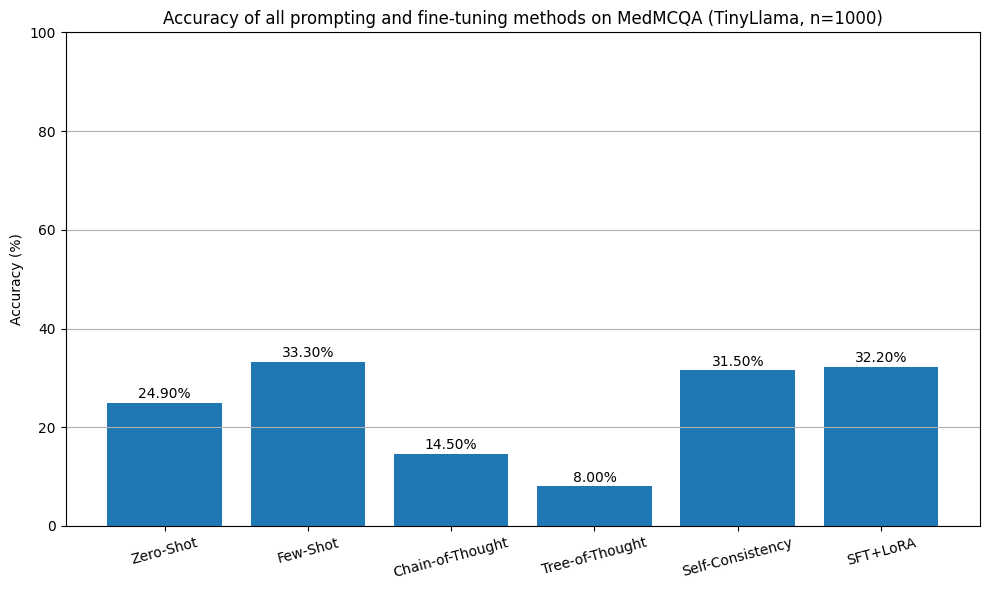

In [ ]:
import matplotlib.pyplot as plt

# Accuracies collected earlier
methods = [
    "Zero-Shot",
    "Few-Shot",
    "Chain-of-Thought",
    "Tree-of-Thought",
    "Self-Consistency",
    "SFT+LoRA"
]

accuracies = [
    acc_zero_shot,
    acc_few_shot,
    acc_cot,
    acc_tot,
    acc_self_consistency,
    0.322
]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(methods, [a * 100 for a in accuracies])
plt.title("Accuracy of all prompting and fine-tuning methods on MedMCQA (TinyLlama, n=1000)")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.grid(True, axis='y')

# Show accuracy value on top of each bar
for bar, acc in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{acc:.2%}", ha='center')

plt.xticks(rotation=15)
plt.tight_layout()
plt.show()